Setup and imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten , Dropout, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D, GlobalAvgPool2D
from keras.applications import ResNet152V2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import random
import cv2
import os
import concurrent.futures
import matplotlib.pyplot as plt

Get input data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Dataset/raw-img'
image_size = 32
class_names = sorted(os.listdir(path))

def process_animal(animal):
    animal_path = path + "/" + animal
    animal_label = animal
    formatted_data = []
    print(f"Started processing animal: {animal_label}")
    for animal_image in os.listdir(animal_path):
        formatted_array = []
        animal_image_array = cv2.imread(animal_path + "/" + animal_image, cv2.IMREAD_GRAYSCALE)
        formatted_array = cv2.resize(animal_image_array, (image_size, image_size))
        formatted_data.append([formatted_array, animal_label])
    print(f"Finished processing animal: {animal_label}")
    return formatted_data

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_animal, class_names))
    print("All tasks have completed.")

formatted_data = [item for sublist in results for item in sublist]

Started processing animal: butterfly
Started processing animal: cat
Started processing animal: chicken
Started processing animal: cow
Started processing animal: dog
Started processing animal: elephant
Finished processing animal: elephant
Started processing animal: horse
Finished processing animal: horse
Started processing animal: sheep
Finished processing animal: sheep
Started processing animal: spider
Finished processing animal: spider
Started processing animal: squirrel
Finished processing animal: squirrel
Finished processing animal: cat
Finished processing animal: cow
Finished processing animal: butterfly
Finished processing animal: chicken
Finished processing animal: dog
All tasks have completed.


In [4]:
random.shuffle(formatted_data)
x_data = []
y_labels = []

# data_gen = ImageDataGenerator(
#       rotation_range=5,
#       width_shift_range=0.01,
#       height_shift_range=0.01,
#       rescale=1./25,
#       shear_range=0.01,
#       zoom_range=0.01)

for image, label in formatted_data:
  x_data.append(image)
  y_labels.append(label)

encoder = LabelEncoder()

train_data, test_data, train_labels, test_labels = train_test_split(x_data, y_labels, test_size=0.2)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2)

train_labels = encoder.fit_transform(train_labels)
test_labels = encoder.transform(test_labels)
val_labels = encoder.transform(val_labels)

x_train = np.array(train_data).reshape(-1,image_size,image_size,1)
x_train = tf.keras.utils.normalize(x_train,axis=1)

# y_train = np.array(train_labels)
# x_train = data_gen.flow(x_train, y_train, shuffle=True)

val_data = np.array(val_data).reshape(-1,image_size,image_size,1)
val_data = tf.keras.utils.normalize(val_data,axis=1)

# val_labels = np.array(val_labels)
# val_data = data_gen.flow(val_data, val_labels, shuffle=True)

test_data = np.array(test_data).reshape(-1,image_size,image_size,1)
test_data = tf.keras.utils.normalize(test_data,axis=1)

y_train = np.array(train_labels)

Building the model

In [5]:
model = Sequential()
model.add(Conv2D(64, 5, activation='relu', input_shape=(image_size, image_size, 1), kernel_regularizer=l2(0.02)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.4))

model.add(Dense(10, activation='softmax'))

In [ ]:
base_model = ResNet152V2(include_top=False, input_shape=(32,32, 3), weights='imagenet')
base_model.trainable = True

resnet152V2 = Sequential([
    base_model,
    GlobalAvgPool2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.4),
    Dense(10, activation='softmax')
], name='ResNet152V2')

resnet152V2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callback = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('ResNet152V2' + ".h5", save_best_only=True, verbose=1)
]

history = resnet152V2.fit(
    x_train, validation_data=(val_data, val_labels),
    epochs=20, callbacks=callback
)

234545216/234545216 [==============================] - 2s 0us/step
Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'resnet152v2' (type Functional).
    
    Input 0 of layer "conv1_conv" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 38, 38, 1)
    
    Call arguments received by layer 'resnet152v2' (type Functional):
      • inputs=tf.Tensor(shape=(None, 32, 32, 1), dtype=float32)
      • training=True
      • mask=None


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 32)                4

Compiling the model

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics='accuracy')

In [8]:
call = [
    EarlyStopping(patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best.h5", save_best_only=True, verbose=1)
]

In [9]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(val_data, val_labels), batch_size=250, callbacks=call)

Epoch 1/50
67/68 [============================>.] - ETA: 0s - loss: 2.7161 - accuracy: 0.2000
Epoch 1: val_loss improved from inf to 2.35608, saving model to best.h5
68/68 [==============================] - 39s 553ms/step - loss: 2.7158 - accuracy: 0.2000 - val_loss: 2.3561 - val_accuracy: 0.1940
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/68 [============================>.] - ETA: 0s - loss: 2.2267 - accuracy: 0.2736
Epoch 2: val_loss did not improve from 2.35608
68/68 [==============================] - 37s 539ms/step - loss: 2.2265 - accuracy: 0.2736 - val_loss: 2.3604 - val_accuracy: 0.2653
Epoch 3/50
67/68 [============================>.] - ETA: 0s - loss: 2.1443 - accuracy: 0.3152
Epoch 3: val_loss did not improve from 2.35608
68/68 [==============================] - 36s 533ms/step - loss: 2.1442 - accuracy: 0.3153 - val_loss: 2.3674 - val_accuracy: 0.1813
Epoch 4/50
67/68 [============================>.] - ETA: 0s - loss: 2.0858 - accuracy: 0.3414
Epoch 4: val_loss improved from 2.35608 to 2.31377, saving model to best.h5
68/68 [==============================] - 39s 568ms/step - loss: 2.0858 - accuracy: 0.3414 - val_loss: 2.3138 - val_accuracy: 0.3183
Epoch 5/50
67/68 [============================>.] - ETA: 0s - loss: 2.0548 - accuracy: 0.3449
Epoch 5: val_loss improved from 2.31377 to 2.26381, saving model to b

In [10]:
loss, accuracy = model.evaluate(test_data, test_labels)

print(f'Test accuracy: {accuracy}')

164/164 [==============================] - 2s 14ms/step - loss: 1.9081 - accuracy: 0.4124
Test accuracy: 0.41237112879753113


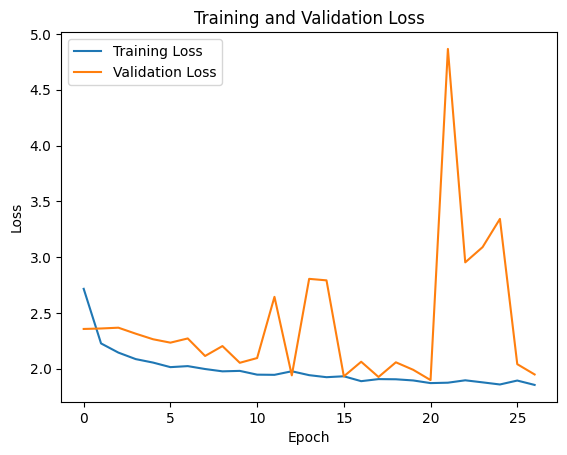

In [11]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()